In [1]:
# Modules required for ML model
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0
!pip install random_user_agent
!pip install transformers
!pip install sentencepiece
!pip install googletrans==4.0.0-rc.1
!pip install nltk
!pip install gTTS
!pip install tkinter

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 462 kB 47.9 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 51.3 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 352 kB 42.7 MB/s 
     |████████████████████████████████| 237 kB 42.3 MB/s 
     |████████████████████████████████| 8.2 MB 5.4 MB/s 
     |████████████████████████████████| 4.2 MB 4.6 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
     |████████████████████████████████| 55 kB 1.4 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |██████████████████████

In [2]:
# Load the required submodules
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
from transformers import BatchEncoding
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pickle
from transformers import XLNetTokenizer, TFXLNetModel,XLNetConfig,XLNetTokenizerFast
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pickle
import pkg_resources
import chardet 
from tqdm import tqdm
import random
from googletrans import Translator
import time
import ast
from random_user_agent.params import SoftwareName, OperatingSystem
import nltk
import json
from tkinter import *
from gtts import gTTS
import os

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
tf.config.experimental.list_physical_devices()
!nvidia-smi
for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
    print(entry_point.dist)
from google.colab import drive
drive.mount('/content/drive')

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

tensorboard 2.8.0
tensorboard-plugin-wit 1.8.1
Mounted at /content/drive


In [5]:
def Pre_Processing(Path):
    df = pd.read_csv(Path) # Loading data
    df = df=df.dropna()   # Dropping null values
    df = df.drop_duplicates(subset=['Name'], keep='last') # Removing Duplicates
    df = df.reset_index(drop=True)
    # Converting Names to lower case and removing stop words (i,me,my...) 
    stop = stopwords.words('english')
    df['Name']=df["Name"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
    # Remove any whitespaces from the objects
    df['Name']=df["Name"].apply(lambda x: x.strip())
    # Remove rows, where the label is present only ones (can't be split)
    df = df.groupby('gtts_language').filter(lambda x : len(x) > 1)
    return df

In [6]:
Input = Pre_Processing(r"/content/drive/My Drive/Input_Data1.csv")
Input.head()

Name gtts_language Language
0   n.malaichamy            ta    Tamil
1  m.agnimadathi            ta    Tamil
2    s.arunkumar            ta    Tamil
3    j.sasikumar            ta    Tamil
4    p.ragupathi            ta    Tamil

In [7]:
data = Input[['Name', 'gtts_language','Language']]           # Making a temp copy 
data['Language_label'] = pd.Categorical(data['gtts_language']) # For categorization
data['gtts_language'] = data['Language_label'].cat.codes  # Categorizing based on language
data.head()

Name  gtts_language Language Language_label
0   n.malaichamy             14    Tamil             ta
1  m.agnimadathi             14    Tamil             ta
2    s.arunkumar             14    Tamil             ta
3    j.sasikumar             14    Tamil             ta
4    p.ragupathi             14    Tamil             ta

In [8]:
# Creating a JSON file inorder to access the language input
Output_Reference = data.drop_duplicates(subset=['gtts_language'], keep='last')         # Get the unique values for Language
Output_Reference = Output_Reference.drop(['Name'],axis=1)                              # 
Output_Reference = Output_Reference.reset_index(drop=True)
json_info = Output_Reference.to_json(orient='index')
with open("/content/drive/My Drive/Language_Code.json", "w") as outfile:
    outfile.write(json_info)
Output_Reference['Language_label'].unique

<bound method Series.unique of 0        ta
1        hi
2     zh-CN
3        cs
4        de
5        es
6        fr
7        el
8        iw
9        it
10       ko
11       nl
12       pl
13       pt
14       ru
15       en
Name: Language_label, dtype: category
Categories (16, object): ['cs', 'de', 'el', 'en', ..., 'pt', 'ru', 'ta', 'zh-CN']>

In [9]:
# Since we have already categorized the language we will not require Language_label
data=data.drop(['Language_label','Language'], axis = 1)
# Split the data for train and test
data, data_test = train_test_split(data, test_size = 0.3, stratify = data[['gtts_language']])
final_data=data
final_data.head()

Name  gtts_language
71123       arrola              4
41059      smitten              1
75661     jourdain              4
46608      amestoy              1
57124  el yaakoubi              4

In [10]:
def create_model():
    # Name of the xlnet model to use
    model_name = 'xlnet-large-cased'
    # Max length of tokens
    max_length = 10
    # Load transformers config and set output_hidden_states to False
    config = XLNetConfig.from_pretrained(model_name)
    config.output_hidden_states = False
    # Load xlnet tokenizer
    tokenizer = XLNetTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
    # Load the Transformers xlnet model
    transformer_model = TFXLNetModel.from_pretrained(model_name, config = config)
    # Load the MainLayer
    xlnet = transformer_model.layers[0]
    # Build your model input
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    inputs = {'input_ids': input_ids}
    # Load the Transformers xlnet model as a layer in a Keras model
    xlnet_model = tf.reduce_mean(xlnet(inputs)[0], axis=1)
    dropout = Dropout(0.1, name='pooled_output')
    pooled_output = dropout(xlnet_model, training=False)
    # Then build your model output
    Lang = Dense(units=len(data.Language_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='issue')(pooled_output)
    outputs = {'gtts_language': Lang}
    # And combine it all in a model object
    model = Model(inputs=inputs, outputs=outputs, name='xlnet_model_MultiLabel_MultiClass')
    # creates an optimizer with learning rate schedule
    # Set an optimizer
    optimizer = Adam(
        learning_rate=5e-05,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)
    # Set loss and metrics
    loss = {'gtts_language': CategoricalCrossentropy(from_logits = True)}
    metric = {'gtts_language': CategoricalAccuracy('accuracy')}
    # Compile the model
    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric)
    # Ready output data for the model
    y_language = to_categorical(data['gtts_language'])

    # Tokenize the input (takes some time)
    x = tokenizer(
        text=data['Name'].to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = False,
        verbose = True)
    # Fit the model
    history = model.fit(
        x={'input_ids': x['input_ids']},
        y={'gtts_language': y_language},
        validation_split=0.2,
        batch_size=64,
        epochs=50)
    return history,model

In [11]:
use_tpu = True
if use_tpu:
    # Create distribution strategy (TPU initialization)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.37.119.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.37.119.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-large-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


TypeError: ignored

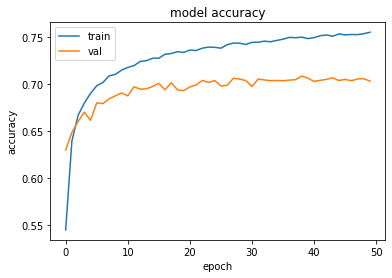

In [ ]:
from matplotlib import pyplot as plt
# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(model[0].history['accuracy'])
plt.plot(model[0].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_y_language = to_categorical(data_test['gtts_language'])
test_x = tokenizer(
    text=data_test['Name'].to_list(),
    add_special_tokens=True,
    max_length=10,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
# Run evaluation
model_eval = model[1].evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'gtts_language': test_y_language}
)

1013/1013 [==============================] - 42s 30ms/step - loss: 0.9858 - accuracy: 0.6942


In [23]:
# Saving the Model and weights as JSON and use latter for prediction
load_model=model[1]
Load_model = load_model.to_json()
with open('/content/drive/My Drive/Lego1_model.json','w') as file:
  file.write(Load_model)
load_model.save_weights('/content/drive/My Drive/Lego1_weights.h5')
with open('/content/drive/My Drive/Language_Code.json') as f:
    Language_Input = json.loads(f.read())

NameError: ignored

In [17]:
# Test Case and Validation
text= 'Saraswathi'
a = tokenizer.encode(
    text= text,
    add_special_tokens=True,
    max_length=10,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
a_as_vector = tf.reshape(a, [-1])
#padding
zero_padding = tf.zeros([1 * 10] - tf.shape(a_as_vector), dtype=a.dtype)
a_reshape=tf.concat([a_as_vector, zero_padding],0)
a_reshape=tf.reshape(a_reshape,[1,10])
d=model[1].predict(a_reshape)
c=np.argmax(d['gtts_language'])
for key, info in Language_Input.items():
    if(info['gtts_language'] == c):
      lang=info['Language']
      print("{} is {}".format(text,lang ))

NameError: ignored

Shreegowri

In [15]:
model_name = 'xlnet-large-cased'
# Load transformers config and set output_hidden_states to False
config = XLNetConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load xlnet tokenizer
tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

In [19]:
from tensorflow.keras.models import model_from_json
json_file = open('/content/drive/My Drive/Lego1_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/My Drive/Lego1_weights.h5")
with open('/content/drive/My Drive/Language_Code.json') as f:
    Language_Input = json.loads(f.read())
 

In [24]:
#@title Name Language prediction
Full_Name= "Brian Sawyer" #@param {type:"string"}
Name = Full_Name.lower()
Name = Name.strip()
a = tokenizer.encode(
    text= Name,
    add_special_tokens=True,
    max_length=10,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)
a_as_vector = tf.reshape(a, [-1])
zero_padding = tf.zeros([1 * 10] - tf.shape(a_as_vector), dtype=a.dtype)
a_reshape=tf.concat([a_as_vector, zero_padding],0)
a_reshape=tf.reshape(a_reshape,[1,10])
d=loaded_model.predict(a_reshape)
c=np.argmax(d['gtts_language'])
lan=""
for key, info in Language_Input.items():
    if(info['gtts_language'] == c):
      lang=info['Language']
      lan=info['Language_label']
      print("{} is {}".format(Full_Name,lang ))
print("==>",lan)

Brian Sawyer is Italian
==> it


In [26]:
root = Tk()


TclError: ignored